# Inverse Problems Exercises: 2024s s05 (non-physics)
https://www.umm.uni-heidelberg.de/miism/

## Notes
* Please **DO NOT** change the name of the `.ipynb` file. 
* Please **DO NOT** import extra packages to solve the tasks. 
* Please put the `.ipynb` file directly into the `.zip` archive without any intermediate folder. 

## Please provide your personal information
* full name (Name): 

YOUR ANSWER HERE

Quang Minh, Ngo

## D02b: Tikhonov approach

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA

In [50]:
file_gaussian = 'file_gaussian.npz'
with np.load(file_gaussian) as data:
    f_true = data['f_true']
    A_psf = data['A_psf']
    list_gn = data['list_gn']

### Imaging model
The imaging model can be represented by
$$
g = h \otimes f_\text{true}
= Af_\text{true}
= \mathcal{F}^{-1}\{ \mathcal{F}\{h\} \mathcal{F}\{f_\text{true}\} \},
$$
$$
g' = g + \epsilon.
$$
* $f_\text{true}$ is the input signal
* $h$ is the point spread function (kernel)
* $\otimes$ is the convolution operator
* $A$ is the Toeplitz matrix of $h$
* $\mathcal{F}$ and $\mathcal{F}^{-1}$ are the Fourier transform operator and inverse Fourier transform operator
* $\epsilon$ is the additive Gaussian noise
* $g$ is the filtered signal
* $g'$ is the noisy signal

### Mean squared error
Implement the mean squared error (MSE)
$$
\operatorname{MSE}(f)=\frac{1}{n}\sum_{i=1}^n(f_i - f_{\text{true}i})^2
$$
* Given the input signal $f$
* Given the true signal $f_\text{true}$
* Implement the function `mean_squared_error()` (using `numpy.array`)

In [51]:
def mean_squared_error(f, f_true):
    """ Compute the mean squared error comparing to the true signal:

    :param f: Input signal.
    :param f_true: True signal.
    :returns: Mean squared error.
    """
    return np.mean((f-f_true)**2)

In [52]:
# This cell contains hidden tests.


### Difference matrix
Implement the difference matrix $D_\text{diff}$
$$D_\text{diff} = \begin{bmatrix} 
1 & 0 & 0 & 0 & ... & 0 & -1 \\
-1 & 1 & 0 & 0 & ... & 0 & 0 \\
0 & -1 & 1 & 0 & ... & 0 & 0 \\
  &   &   & ... &   &   & \\
0 & 0 & 0 & 0 & ... & -1 & 1 \end{bmatrix}$$
* Given the size $n_\text{diff}$
* Note the $-1$ on the top right of the matrix
* Implement the function `get_diff_matrix()` (using `numpy.array`)

Calculate the difference matrix
* Return the outputs of with the size of $10$, $50$, $100$, respectively
* Save the outputs in the variable `list_D_diff` (as `list` of `numpy.array`)

Display the result
* Plot the matrices in `list_D_diff` as grayscale images in the same order of the parameter options in the subplots of `axs`
* Show the colorbar of each subplot
* Add proper titles to the subplots of `axs`

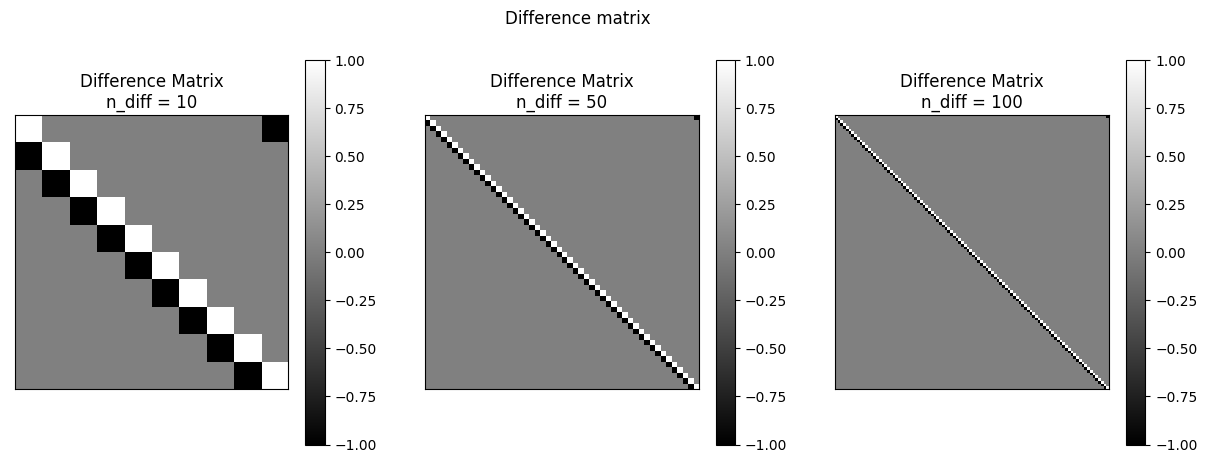

In [53]:
def get_diff_matrix(n):
    """ Compute a matrix to calculate the difference along a vector of the size n
    between two neighboring elements.

    :param n: Size of the target vector.
    :returns: Matrix with shape (n, n), which calculates the difference.
    """
    matr = np.zeros((n, n))
    matr[0, 0] = 1
    matr[0, -1] = -1
    for i in range(1, n):
        matr[i, i] = 1
        matr[i, i-1] = -1
    return matr

list_n = [10, 50, 100]
list_D_diff = [get_diff_matrix(n) for n in list_n]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Difference matrix')

for i, (D_diff, size) in enumerate(zip(list_D_diff, list_n)):
    cax = axs[i].matshow(D_diff, cmap='gray')
    fig.colorbar(cax, ax=axs[i])
    axs[i].set_title(f'Difference Matrix\nn_diff = {size}')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()
    

In [54]:
# This cell contains hidden tests.


In [55]:
# This cell contains hidden tests.


### Tikhonov regularization
Implement the objective function with Tikhonov regularization
$$
L(f) = \|Af - g'\|_2^2 + \lambda\|D'f\|_2^2
$$
* Given the input signal $f$
* Given the system matrix $A$
* Given the measurement $g'$
* Given the regularization matrix $D'$
* Given the regularization parameter $\lambda$
* Implement the function `objective_tikhonov()` (using `numpy.array`)

Implement the closed form solution of the regularized objective function
$$
\tilde f = (A^T A + \lambda D'^T D')^{-1} A^T g' = A_\lambda^{PI} g'
$$
* Given the system matrix $A$
* Given the measurement $g'$
* Given the regularization matrix $D'$
* Given the regularization parameter $\lambda$
* Implement the function `solution_tikhonov()` (using `numpy.array`)

In [56]:
def objective_tikhonov(f, A, g, D, lb):
    """ Compute the objective function with Tikhonov regularization.
    
    :param f: Current estimate of the signal.
    :param A: 2D matrix of the linear problem.
    :param g: Observed signal.
    :param D: 2D matrix in the regularization term.
    :param lb: Regularization parameter.
    :returns: Objective function value.
    """
    squared_normed_residual = LA.norm((np.dot(A, f) - g), 2)**2
    
    # Handeling the case when D is a zero matrix
    if np.all(D == 0):
        return squared_normed_residual
    
    squared_normed_regularization = LA.norm(np.dot(D, f), 2)**2
    return squared_normed_residual + lb * squared_normed_regularization
    
def solution_tikhonov(A, g, D, lb):
    """ Compute the estimate of the true signal with Tikhonov regularization.

    Use a regularization term to suppress noise.

    :param A: 2d matrix A of the linear problem.
    :param g: Observed signal.
    :param D: 2D matrix in the regularization term.
    :param lb: Regularization parameter.
    :returns: Estimate of the true signal.
    """
    # Handeling the case when D is a zero matrix
    if np.all(D == 0):
        return np.dot(LA.inv(np.dot(A.T, A)), np.dot(A.T, g))
    
    return np.dot(LA.inv(np.dot(A.T,  A) + lb * np.dot(D.T, D)), np.dot(A.T, g))

In [57]:
# This cell contains hidden tests.


In [58]:
# This cell contains hidden tests.


### Best fit solution
The best fit solution is the solution without regularization, i.e. $D' = 0$
* Calculate the closed form solution for the noisy signals in `list_gn`
* Save the outputs in the variable `list_f_est` (as `list` of `numpy.array`)

Display the result
* Plot the outputs in `list_f_est` in the same order of the parameter options in the subplots of `axs`
* Plot the corresponding noisy signal in each subplot
* Plot the input signal `f_true` in each subplot
* Show the legend in each subplot
* Show the case information in the titles to the subplots
* Show the mean squared error of each output comparing to `f_true` in the titles to the subplots
* Show the objective function value of each output in the titles to the subplots

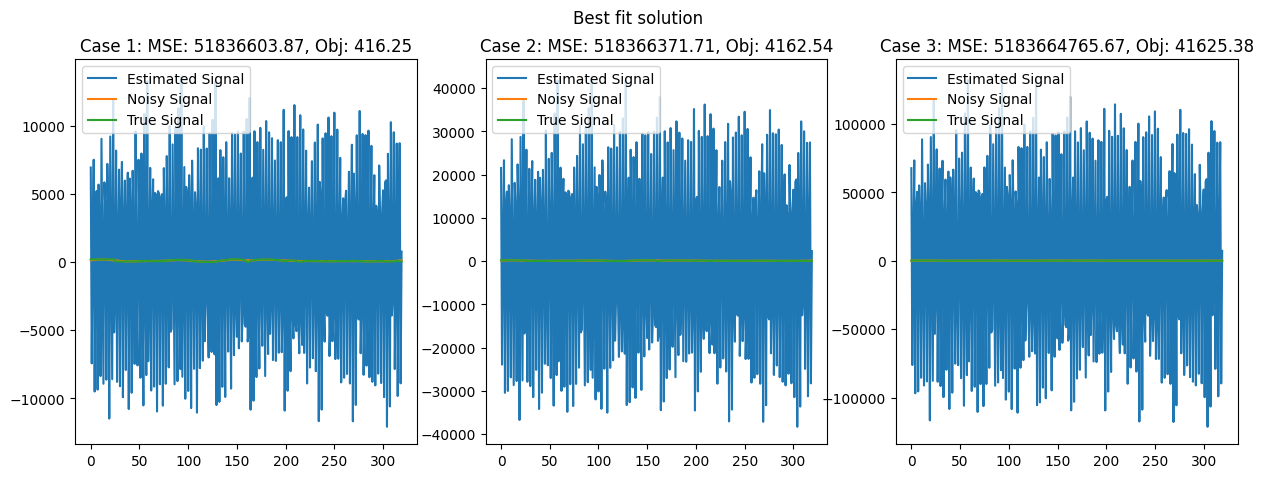

In [59]:
list_f_est = [solution_tikhonov(A_psf, g, 0, 0.1) for g in list_gn]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Best fit solution')

for i, (f_est, g) in enumerate(zip(list_f_est, list_gn)):
    axs[i].plot(f_est, label='Estimated Signal')
    axs[i].plot(g, label='Noisy Signal')
    axs[i].plot(f_true, label='True Signal')

    # Calculate mean squared error
    mse = mean_squared_error(f_est, f_true)

    # Calculate objective function value
    obj_val = objective_tikhonov(f_true, A_psf, g, 0, 0)

    # Set title with case information
    axs[i].set_title(f"Case {i+1}: MSE: {mse:.2f}, Obj: {obj_val:.2f}")

    # Show legend
    axs[i].legend()
plt.show()

In [60]:
# This cell contains hidden tests.


### Question: Noise
Why does this solution amplify the noise?

YOUR ANSWER HERE
There are some reasons:
-   System matrix A can be ill-conditioned which means small errors of g can affect immensely to $\tilde f$.
-   Without regularization but $\tilde f = (A^T A)^{-1} A^T g'$ will amplify the noise.
-   Exclude the term $\lambda\|D'f\|_2^2$ will lead to considerable fluctuations of $\tilde f$ due to amplified noise.

### Minimal length solution
The minimal length solution is the solution with $D' = I$
* Calculate the closed form solution for the noisy signals in `list_gn`
* Return the outputs with $\lambda$ of $0.1$, $0.01$, $0.001$, respectively 
* Save the outputs in the variable `list_f_est` (as `list` of `numpy.array`)

Display the result
* Plot the outputs in `list_f_est` in the same order of the parameter options in the subplots of `axs`
* Show the cases of the same noisy signal in the same subplot column
* Show the cases with the same $\lambda$ in the same subplot row
* Plot the corresponding noisy signal in each subplot
* Plot the input signal `f_true` in each subplot
* Show the legend in each subplot
* Show the case information in the titles to the subplots
* Show the mean squared error of each output comparing to `f_true` in the titles to the subplots
* Show the objective function value of each output in the titles to the subplots

<class 'list'>


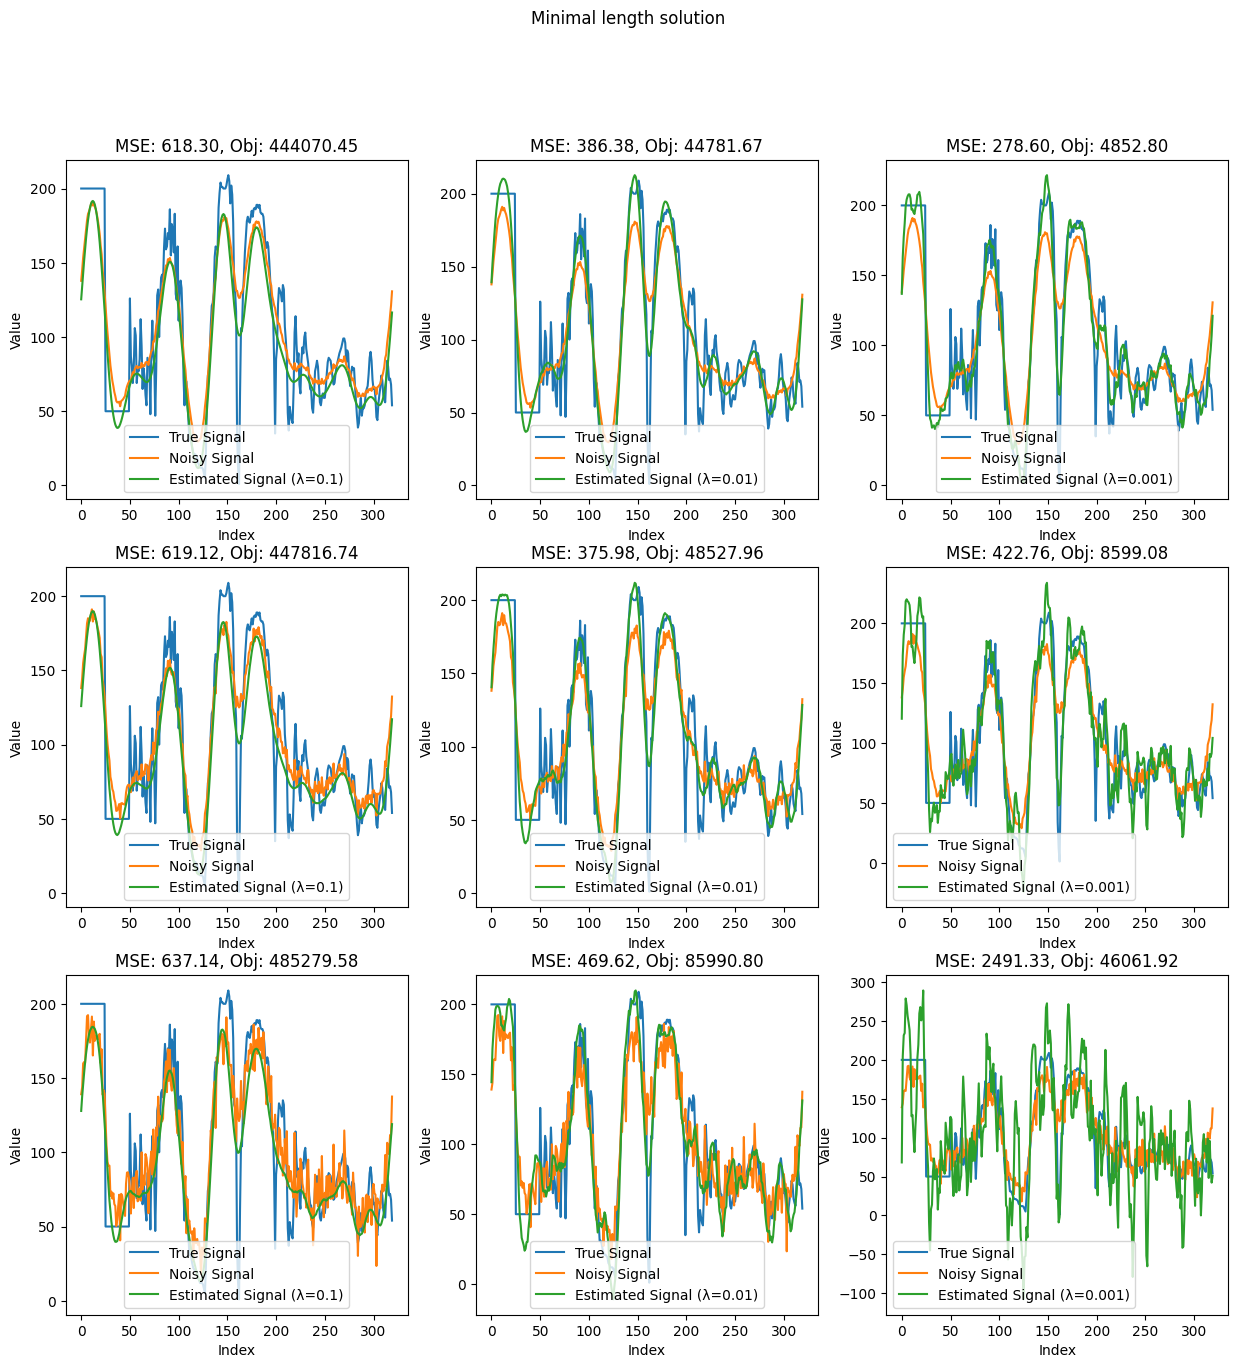

In [61]:
list_f_est = []
list_lb = [0.1, 0.01, 0.001]
I = np.eye(A_psf.shape[1])
for lb in list_lb:
    list_f_est.append([solution_tikhonov(A_psf, g, I, lb) for g in list_gn])
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Minimal length solution')
for i, g in enumerate(list_gn):
    for j, lb in enumerate(list_lb):
        f_est = list_f_est[j][i]
        mse = mean_squared_error(f_est, f_true)
        obj_func_value = objective_tikhonov(f_true, A_psf, g, np.eye(A_psf.shape[1]), lb)
        axs[i, j].plot(f_true, label='True Signal')
        axs[i, j].plot(g, label='Noisy Signal')
        axs[i, j].plot(f_est, label=f'Estimated Signal (λ={lb})')
        axs[i, j].legend()
        axs[i, j].set_title(f'MSE: {mse:.2f}, Obj: {obj_func_value:.2f}')
        axs[i, j].set_xlabel('Index')
        axs[i, j].set_ylabel('Value')
plt.show()

In [62]:
# This cell contains hidden tests.


### Gradient magnitude solution
The gradient magnitude solution is the solution with $D' = D_\text{diff}$
* Calculate the closed form solution for the noisy signals in `list_gn`
* Return the outputs with $\lambda$ of $0.1$, $0.01$, $0.001$, respectively 
* Save the outputs in the variable `list_f_est` (as `list` of `numpy.array`)

Display the result
* Plot the outputs in `list_f_est` in the same order of the parameter options in the subplots of `axs`
* Show the cases of the same noisy signal in the same subplot column
* Show the cases with the same $\lambda$ in the same subplot row
* Plot the corresponding noisy signal in each subplot
* Plot the input signal `f_true` in each subplot
* Show the legend in each subplot
* Show the case information in the titles to the subplots
* Show the mean squared error of each output comparing to `f_true` in the titles to the subplots
* Show the objective function value of each output in the titles to the subplots

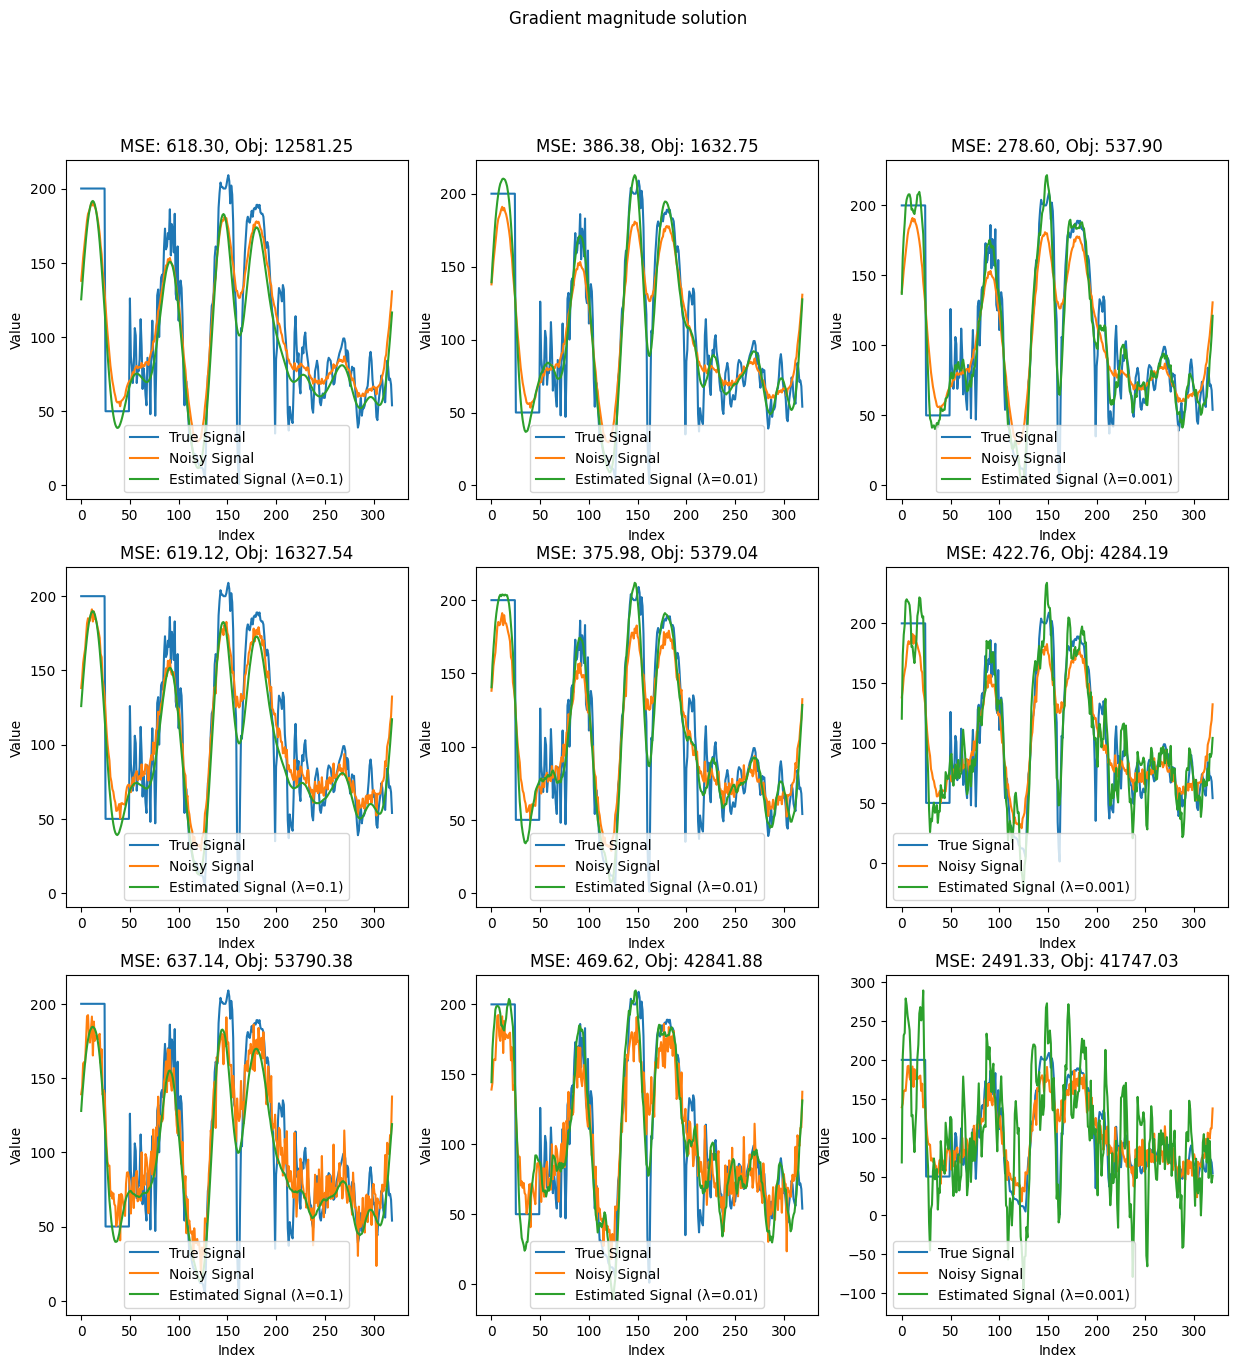

In [63]:
D_diff = get_diff_matrix(A_psf.shape[1])
for lb in list_lb:
    list_f_est.append([solution_tikhonov(A_psf, g, D_diff, lb) for g in list_gn])
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Gradient magnitude solution')

for i, g in enumerate(list_gn):
    for j, lb in enumerate(list_lb):
        f_est = list_f_est[j][i]
        mse = mean_squared_error(f_est, f_true)
        obj_func_value = objective_tikhonov(f_true, A_psf, g, D_diff, lb)
        axs[i, j].plot(f_true, label='True Signal')
        axs[i, j].plot(g, label='Noisy Signal')
        axs[i, j].plot(f_est, label=f'Estimated Signal (λ={lb})')
        axs[i, j].legend()
        axs[i, j].set_title(f'MSE: {mse:.2f}, Obj: {obj_func_value:.2f}')
        axs[i, j].set_xlabel('Index')
        axs[i, j].set_ylabel('Value')

plt.show()

In [64]:
# This cell contains hidden tests.


### Question: Regularization
 1. How can the different reconstruction techniques be characterized when comparing the results, especially for corners or edges?
 2. What is the consequence when changing $\lambda$, especially for very small and very large values, as observed on the solution?

YOUR ANSWER HERE

1. Different reconstruction techniques:
   - D = 0:
        +   Solution is highly sensitive to noise
        +   Edges and corners are often blurred due to noise amplification
   - D is an Identity matrix:
        +   Noises are reduced due to Tikhonov regularization penalizes heavily on large values of f.
        +   Edges and corners are still blurred but better than D = 0
   - D is a difference matrix: 
        +   Noises are reduced effectively and the details are well-preserved
        +   Edges and corners are clearer
        +   The objective function is minimal in this method compared to other methods.
2. Results based on $\lambda$:
   - $\lambda$ is very small: reconstruction is noisy and regularization is minimal which causes blurred or lost for edges and corners
   - $\lambda$ is moderate: balance regularization and well preserved details
   - $\lambda$ is very large: strong regularization and exaggerated smooth reconstruction leads to blurred edges and corners